In [1]:
from rsl_depth_completion.data.components import raw_data_loaders as dl
from rsl_depth_completion.data.components import camera_calibration as calib

In [2]:
sparse_dm = dl.depth_read("/media/master/wext/cv_data/kitti-full/data/kitti_depth_completion/validation/sparse_depth/2011_09_26_drive_0002_sync_velodyne_raw_0000000005_image_02.png")
gt = dl.depth_read("/media/master/wext/cv_data/kitti-full/data/kitti_depth_completion/validation/ground_truth/2011_09_26_drive_0002_sync_groundtruth_depth_0000000005_image_02.png")
rgb_image=dl.img_read("/media/master/wext/cv_data/kitti-full/data/kitti_depth_completion/validation/image/2011_09_26_drive_0002_sync_image_0000000005_image_02.png")
intrinsics = calib.load_calib("/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/data/kitti-calibration")

In [3]:
import matplotlib.pyplot as plt
import numpy as np


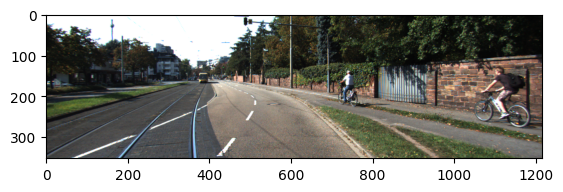

In [4]:
plt.imshow(rgb_image)

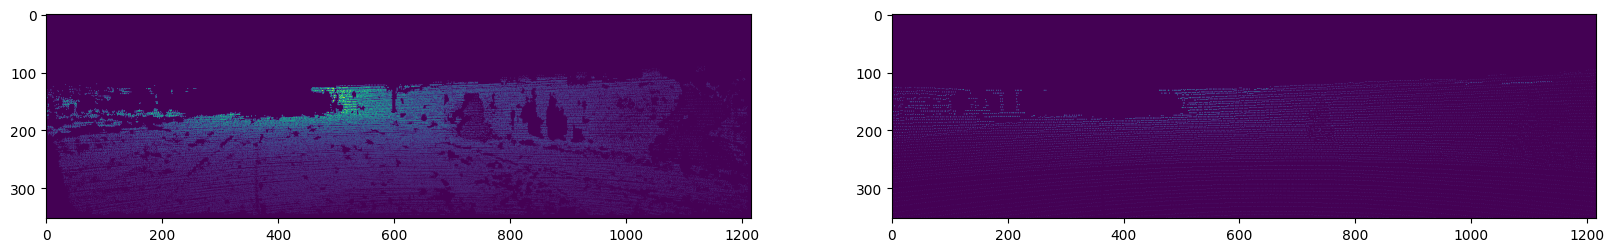

In [5]:
fix, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(gt)
ax[1].imshow(sparse_dm)

In [6]:
import torch

torch.save(torch.from_numpy(sparse_dm.astype('float32')).permute(2,0,1), "/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/sparse_dm.pt")
torch.save(torch.from_numpy(rgb_image.astype('float32')).permute(2,0,1), "/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/rgb_image.pt")

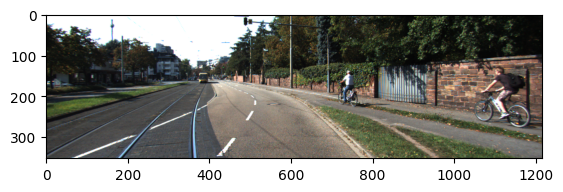

In [7]:
import torch
plt.imshow(torch.load("/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/rgb_image.pt").numpy().transpose(1,2,0)/255)

In [8]:
torch.save(torch.from_numpy(sparse_dm.astype('float32').transpose(2,0,1)), "/media/master/wext/msc_studies/second_semester/research_project/project/rsl_depth_completion/rsl_depth_completion/conditional_diffusion/sparse_dm.pt")

In [9]:
max_depth=80.0
loaded_rgb_image = torch.load(
    "./rgb_image.pt"
)
loaded_sparse_dm = (
    torch.load(
        "./sparse_dm.pt"
    )
    / max_depth
)

In [10]:
loaded_rgb_image.max()

tensor(255.)

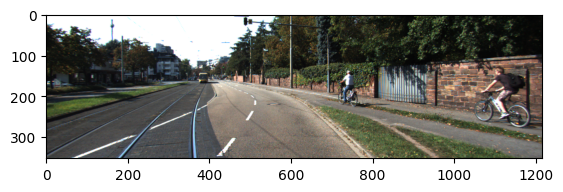

In [11]:
plt.imshow(loaded_rgb_image.numpy().transpose(1,2,0)/255)

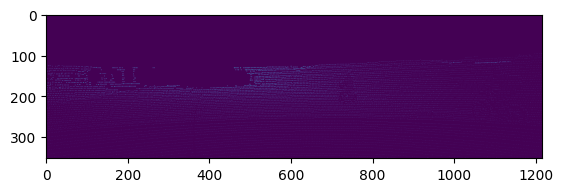

In [12]:
plt.imshow(loaded_sparse_dm.numpy().transpose(1,2,0)/80)

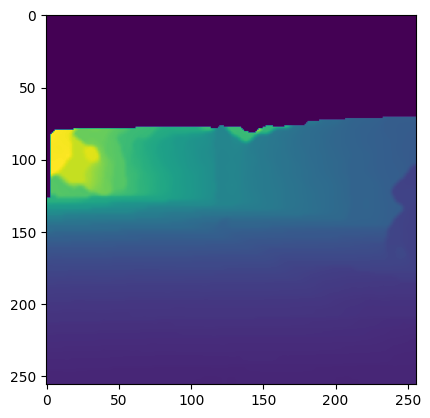

In [24]:
import torchvision as tv
import cv2
crop_size = (256,256)
rescale_size = (64,64)

from img_utils import center_crop


# plt.imshow(transform(loaded_sparse_dm).numpy().transpose(1,2,0)/80)
cropped = center_crop(loaded_sparse_dm, crop_size, channels_last=False)
from rsl_depth_completion.conditional_diffusion import utils as data_utils
cropped_interpolated = data_utils.interpolate_sparse_depth(cropped.squeeze().numpy(), do_multiscale=True)[:,:,np.newaxis]
plt.imshow(cropped_interpolated)
plt.show()

# plt.imshow(cropped.permute(1,2,0)/80)
# plt.show()

def resize_cv2(rescale_size, cropped, interpolation=cv2.INTER_AREA):
    init_shape = cropped.shape
    x = cv2.resize(cropped.numpy().transpose(1,2,0), rescale_size, interpolation=interpolation)
    x = x.reshape(rescale_size[0], rescale_size[1], init_shape[0])
    return x

# for interpolation in [cv2.INTER_AREA, cv2.INTER_CUBIC]:
#     resized = resize_cv2(rescale_size, cropped, interpolation)
#     plt.imshow(resized/80)
#     plt.title(interpolation)
#     plt.show()

def resize_torch(rescale_size, cropped, interpolation=tv.transforms.InterpolationMode.BICUBIC):
    antialias=True if interpolation == tv.transforms.InterpolationMode.BICUBIC or interpolation == tv.transforms.InterpolationMode.BILINEAR else False
    transform = tv.transforms.Compose([
        tv.transforms.Resize(rescale_size, antialias=antialias, interpolation=interpolation),
    ])
    resized = transform(cropped)
    return resized

# for interpolation in [tv.transforms.InterpolationMode.BICUBIC, tv.transforms.InterpolationMode.BILINEAR, tv.transforms.InterpolationMode.NEAREST]:
#     resized = resize_torch(rescale_size, cropped, interpolation)
#     plt.imshow(resized.numpy().transpose(1,2,0)/80)
#     plt.title(interpolation)
#     plt.show()
# plt.imshow(cropped.numpy().transpose(1,2,0)/80)

In [30]:
cropped.shape

torch.Size([1, 256, 256])

cropped_interpolated

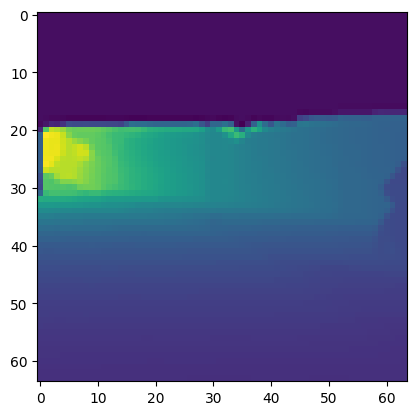

In [31]:
resized = resize_torch(rescale_size, torch.from_numpy(cropped_interpolated.transpose(2,0,1)))
plt.imshow(resized.numpy().transpose(1,2,0)/80)
# plt.show()
# plt.imshow(data_utils.infill_sparse_depth(resized.numpy(), method="nearest")[0])
# plt.imshow(data_utils.interpolate_sparse_depth(resized.squeeze().numpy(), do_multiscale=True, extrapolate=False,))
plt.show()